<a href="https://colab.research.google.com/github/CoderAPS/HuBMAP/blob/main/HuBMAP_create_mask_20230601.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# imports libraries
import glob
import os
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import cv2
from PIL import Image
from scipy.ndimage import label
from tqdm.notebook import tqdm_notebook

%matplotlib inline

In [2]:
# Check RAM
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
# Mount google drive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [6]:
!ls /gdrive/MyDrive/DATA/HuBMAP/

annotation_info.csv  masks_4d		    test_list.csv   wsi_meta.csv
images		     polygons.jsonl	    tile_meta.csv
images_info.csv      sample_submission.csv  train_list.csv
masks		     test		    val_list.csv


In [ ]:
# Create folder for the storing the created mask
#mask_file_path = '/gdrive/MyDrive/DATA/HuBMAP/masks'
#os.makedirs(mask_file_path)

In [7]:
# Obtain list of all images in train folder
file_path = '/gdrive/MyDrive/DATA/HuBMAP/'
images = glob.glob(file_path + 'images/*')

In [8]:
images[:10]

['/gdrive/MyDrive/DATA/HuBMAP/images/da693ca2093c.tif',
 '/gdrive/MyDrive/DATA/HuBMAP/images/daf9eb07acd4.tif',
 '/gdrive/MyDrive/DATA/HuBMAP/images/db047e105270.tif',
 '/gdrive/MyDrive/DATA/HuBMAP/images/da5cca9855f5.tif',
 '/gdrive/MyDrive/DATA/HuBMAP/images/dbb355ee6c9a.tif',
 '/gdrive/MyDrive/DATA/HuBMAP/images/dbbbdfb26928.tif',
 '/gdrive/MyDrive/DATA/HuBMAP/images/db8391d91d8d.tif',
 '/gdrive/MyDrive/DATA/HuBMAP/images/db59e2824230.tif',
 '/gdrive/MyDrive/DATA/HuBMAP/images/da21c48a3503.tif',
 '/gdrive/MyDrive/DATA/HuBMAP/images/db73a602bf72.tif']

In [9]:
# Create a dictionary to hold the annotations for each image
annotations = {}

# Open the annotations file
with open(file_path + '/polygons.jsonl', 'r') as f:
    # For each line in the file
    for line in f:
        # Parse the line as JSON
        annotation = json.loads(line)

        # Get the image ID and the list of annotations for this image
        image_id = annotation['id']
        image_annotations = annotation['annotations']

        # Store the annotations in the dictionary
        annotations[image_id] = image_annotations

In [10]:
list(annotations.keys())[:4]

['0006ff2aa7cd', '00168d1b7522', '0033bbc76b6b', '003504460b3a']

In [11]:
image_map = {path.split('/')[-1].split('.')[0]: path for path in images}

In [12]:
list(image_map.values())[:3]

['/gdrive/MyDrive/DATA/HuBMAP/images/da693ca2093c.tif',
 '/gdrive/MyDrive/DATA/HuBMAP/images/daf9eb07acd4.tif',
 '/gdrive/MyDrive/DATA/HuBMAP/images/db047e105270.tif']

In [13]:
# Convert image color to RGB and resize images to 512 X 512
def preprocess_image(image):
    # Convert the image from BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Resize image
    image_resized = cv2.resize(image_rgb, (512 , 512))

    return image_resized


  0%|          | 0/1633 [00:00<?, ?it/s]

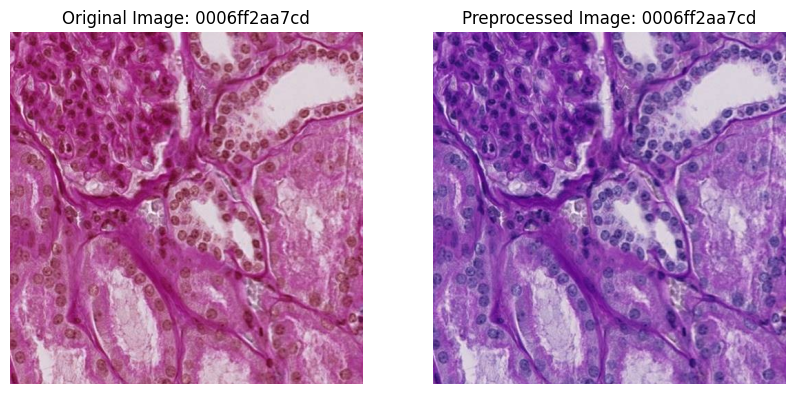

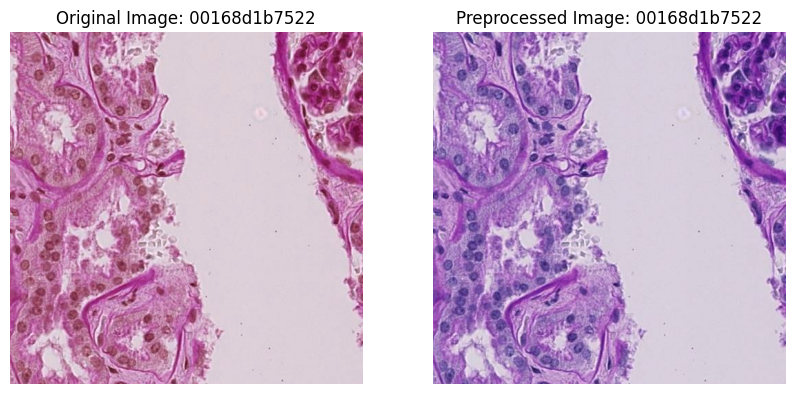

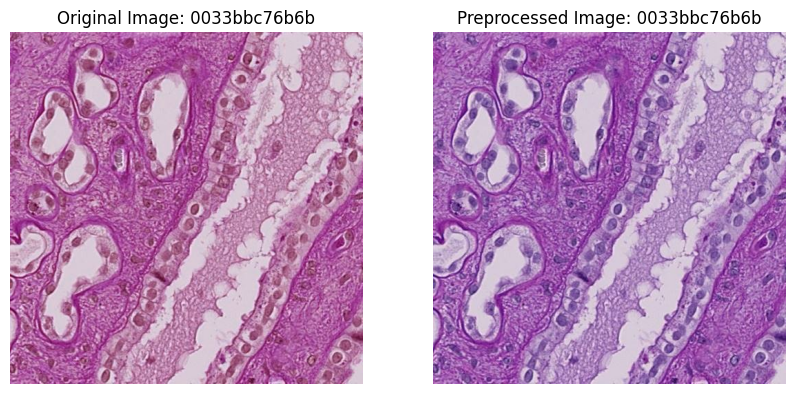

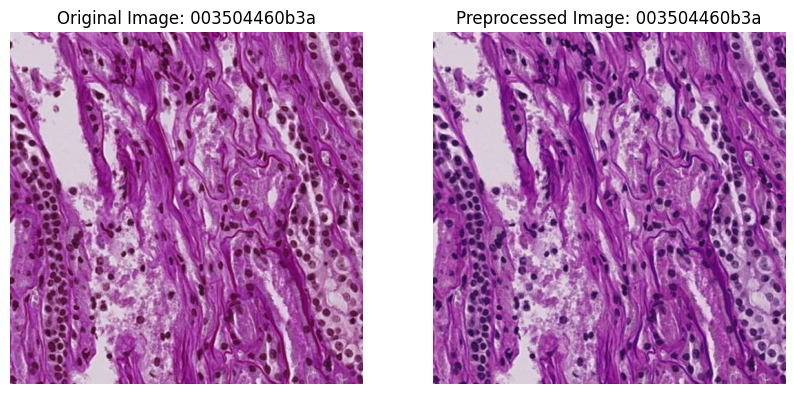

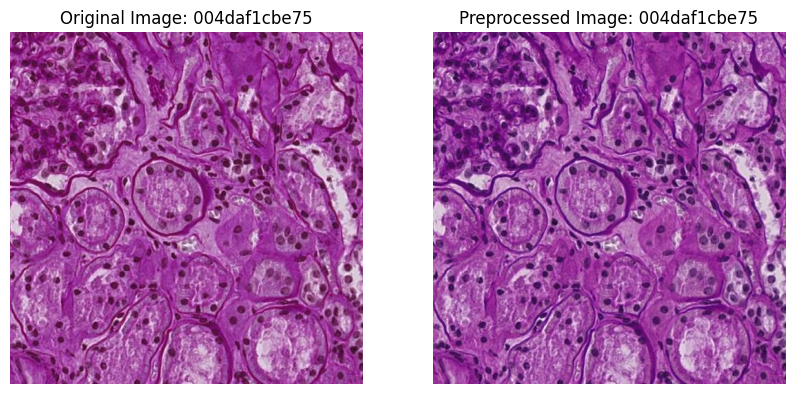

In [15]:
# Load images, preprocess and display the first five original and preprocessed
# images
images_with_annotations = {}
for i, image_id in tqdm_notebook(enumerate(list(annotations.keys())),total=len(annotations)):
    # Open the image file
    if image_id in image_map:
        image = cv2.imread(image_map[image_id])
        preprocessed_image = preprocess_image(image.copy())
        
        images_with_annotations[image_id] = preprocessed_image

         # For the first 5 images, display the original and preprocessed image side by side
        if i < 5:
             plt.figure(figsize=(10, 5))

             plt.subplot(1, 2, 1)
             plt.imshow(image)
             plt.title("Original Image: " + image_id)
             plt.axis('off')

             plt.subplot(1, 2, 2)
             plt.imshow(preprocessed_image)
             plt.title("Preprocessed Image: " + image_id)
             plt.axis('off')

             plt.show()

In [16]:
# Create binary masks and display results for first 5
def display_images_masks_overlays(image, masks, image_id):
    overlay = image.copy()
    # colors for blood vessels, glomerulus and unsure respectively
    colors = [(0, 255, 0), (255, 0, 0), (0, 0, 255)]  

    # Initialize dictionary to hold annotation counts
    annotation_counts = {}
    
    for idx, (annotation_type, mask) in enumerate(masks[image_id].items(), 0):
        # Count the number of distinct areas in the mask
        labeled, num_areas = label(mask)
        annotation_counts[annotation_type] = num_areas

        # update overlay
        overlay[mask > 0] = colors[idx]

    # print annotation counts
    print(f"Annotation counts for image {image_id}: {annotation_counts}")

    # prepare for subplot
    plt.figure(figsize=(25,5))

    # plot the original image
    plt.subplot(1,5,1)
    plt.imshow(image)
    plt.title('Image')
    plt.axis('off')
    
    for idx, (annotation_type, mask) in enumerate(masks[image_id].items(), 2):
        # plot the binary masks
        plt.subplot(1,5,idx)
        plt.imshow(mask, cmap='gray')
        plt.title(f'{annotation_type} mask')
        plt.axis('off')

    # plot the overlay
    plt.subplot(1,5,5)
    plt.imshow(image)  # Use RGB image
    plt.imshow(overlay, alpha=0.4)  # change alpha to adjust transparency
    plt.title('Overlay')
    plt.axis('off')
    plt.show()

  0%|          | 0/1633 [00:00<?, ?it/s]

Annotation counts for image 0006ff2aa7cd: {'blood_vessel': 8, 'glomerulus': 1, 'unsure': 0}


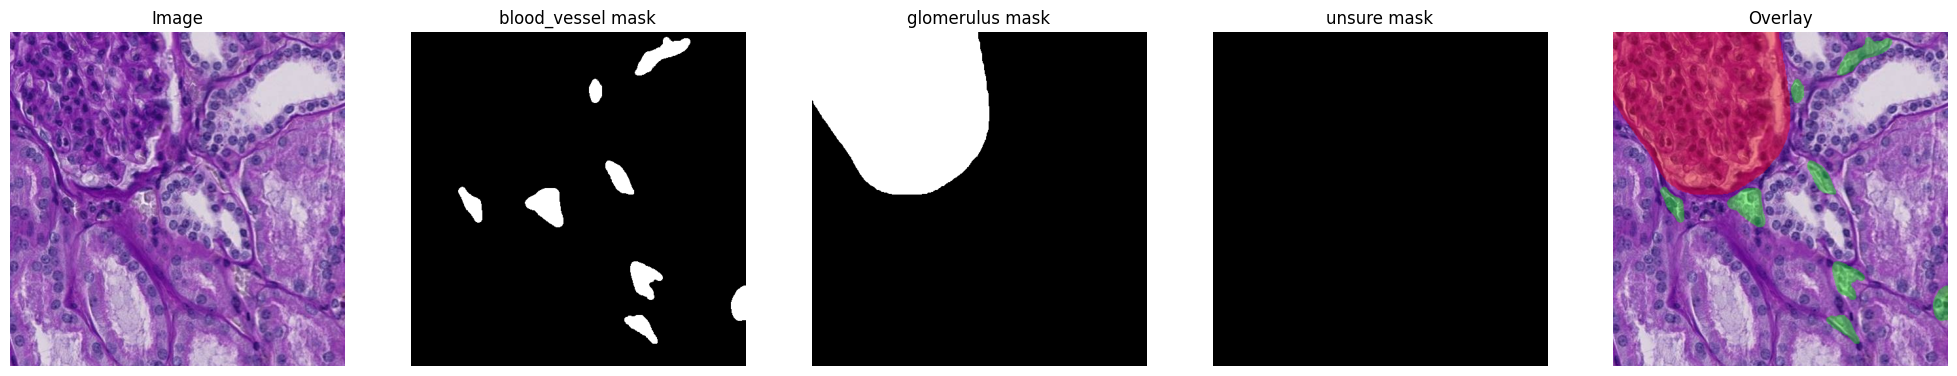

Annotation counts for image 00168d1b7522: {'blood_vessel': 1, 'glomerulus': 1, 'unsure': 0}


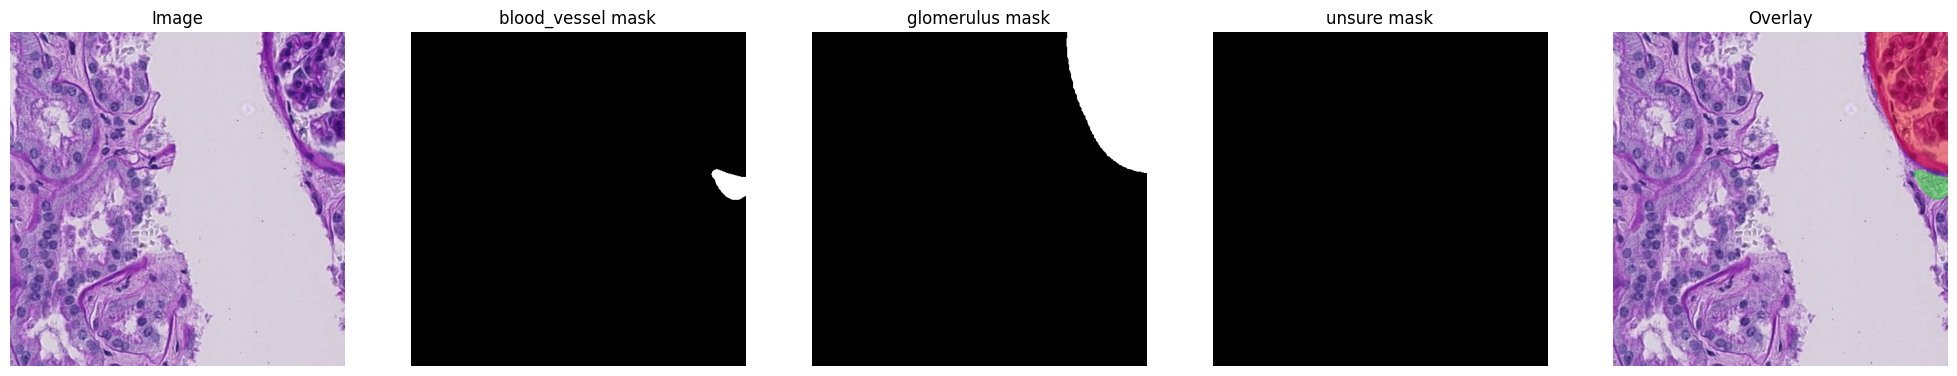

Annotation counts for image 0033bbc76b6b: {'blood_vessel': 3, 'glomerulus': 0, 'unsure': 1}


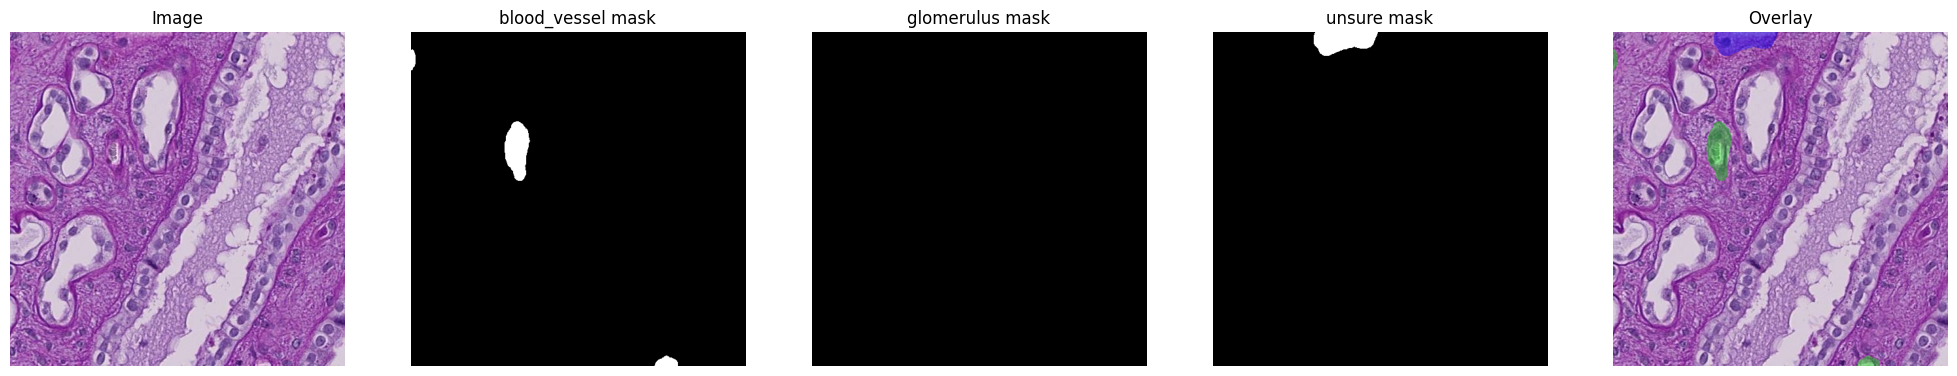

Annotation counts for image 003504460b3a: {'blood_vessel': 7, 'glomerulus': 0, 'unsure': 0}


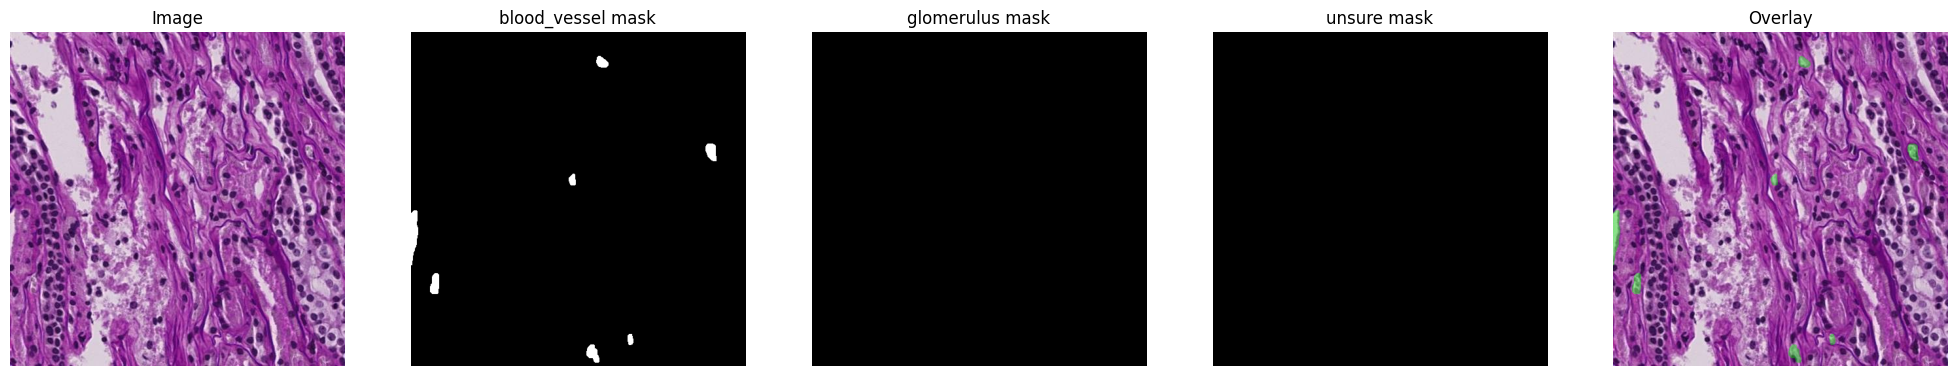

Annotation counts for image 004daf1cbe75: {'blood_vessel': 9, 'glomerulus': 1, 'unsure': 0}


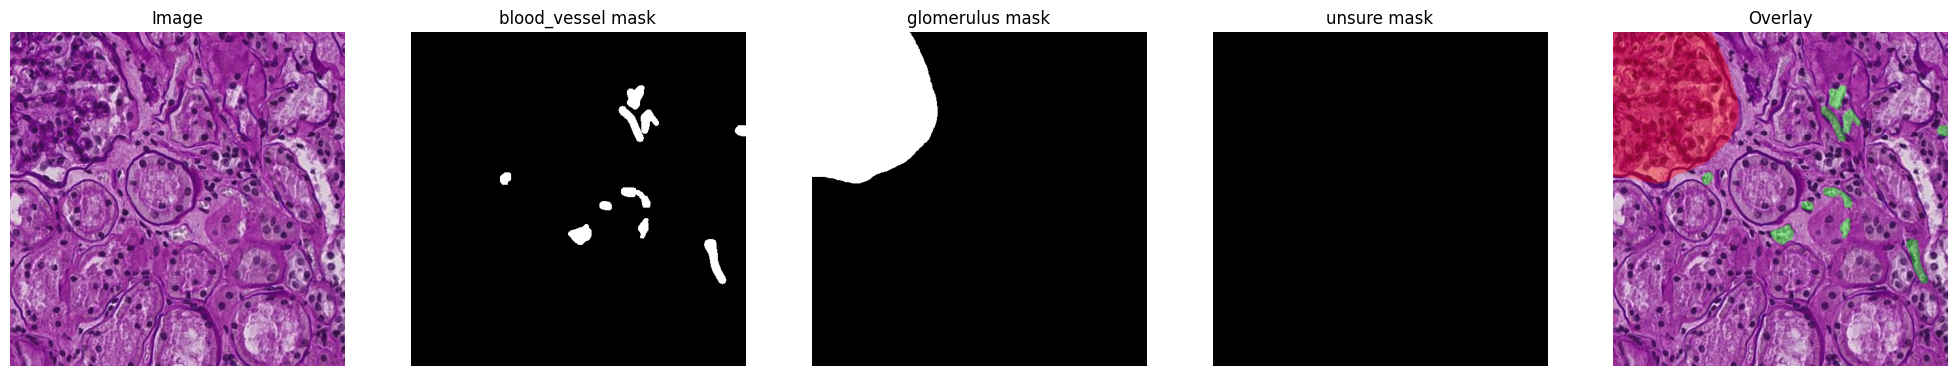

In [17]:

line_1a = None
line_1b = None
binary_masks = {}
annotation_types = ['blood_vessel', 'glomerulus', 'unsure']
for image_id in tqdm_notebook(annotations.keys(),total=len(annotations)):
    if image_id in images_with_annotations:
        polygons = annotations[image_id]
        # Load the preprocessed image
        image = images_with_annotations[image_id]

        # Create an empty mask of the same size as the image
        binary_masks[image_id] = {annotation_type: np.zeros(image.shape[:2], 
                    dtype=np.uint8) for annotation_type in annotation_types}

        # For each polygon
        for polygon in polygons:
            annotation_type = polygon['type']
            lines = np.array(polygon['coordinates'])
            #line_1a = lines
            lines = lines.reshape(-1, 1, 2)
            # Draw the polygon on the mask
            cv2.fillPoly(binary_masks[image_id][annotation_type], [lines], 255)
            #line_1b = lines

        # Display the image and its masks if it's one of the first 5 images
        if len(binary_masks) <= 5:
            display_images_masks_overlays(image, binary_masks, image_id)

In [ ]:
line_1b.shape

(59, 1, 2)

In [60]:
list(binary_masks.keys())[:6]

['0006ff2aa7cd',
 '00168d1b7522',
 '0033bbc76b6b',
 '003504460b3a',
 '004daf1cbe75',
 '005715f0a313']

In [134]:
os.mkdir('/gdrive/MyDrive/DATA/HuBMAP/masks_4d_alt/')

In [137]:
!ls /gdrive/MyDrive/DATA/HuBMAP/

annotation_info.csv  masks_4d		    test	    val_list.csv
images		     masks_4d_alt	    test_list.csv   wsi_meta.csv
images_info.csv      polygons.jsonl	    tile_meta.csv
masks		     sample_submission.csv  train_list.csv


In [ ]:
mask_file_path = '/gdrive/MyDrive/DATA/HuBMAP/masks/'

In [ ]:
#@title hide
# version_1
# make final mask with all four classifications
idx = 0
for mask_id in tqdm_notebook(list(binary_masks.keys()),total=10):
  final_mask = np.zeros((len(binary_masks[mask_id]['blood_vessel']),
               len(binary_masks[mask_id]['blood_vessel'])),dtype=np.uint8)
  
  for row in range(final_mask.shape[0]):
    for col in range(final_mask.shape[1]):
        if binary_masks[mask_id]['blood_vessel'][row][col] == 255:
            final_mask[row][col] = 1.
        elif binary_masks[mask_id]['glomerulus'][row][col] == 255:
                final_mask[row][col] = 2.
        elif binary_masks[mask_id]['unsure'][row][col] == 255:
                final_mask[row][col] = 3.
        else:
                final_mask[row][col] = 0.


    palette = [128,128,128,     # 0=gray
            255,0,0,          # 1= red
            255,255,0,        # 2=yellow
            0,0,255]          # 3=blue
  
  # Pad with zeroes to 768 values, i.e. 256 RGB colours
  palette = palette + [0]*(768-len(palette))

  # Convert Numpy array to palette image
  mask_pi = Image.fromarray(final_mask,'P')

  # Put the palette in
  mask_pi.putpalette(palette)
  
  mask_pi.save('/gdrive/MyDrive/DATA/HuBMAP/temp_mask/'+ mask_id + '_mask.tif')
  idx += 1
  if idx == 10: break
  #cv2.imwrite(mask_file_path + mask_id + '_mask.tif',final_mask)

In [140]:
# version_2
# make final mask with all four classifications

for mask_id in tqdm_notebook(list(binary_masks.keys()),total=len(binary_masks)):
  
  blood_vessel = binary_masks[mask_id]['blood_vessel']
  glomerulus = binary_masks[mask_id]['glomerulus']
  unsure = binary_masks[mask_id]['unsure']
  
  # Reassign distinct pixel values for blood, glomerulus and unsure
  # For background the value of zero is assigned
  blood_vessel[blood_vessel == 255] = 1
  glomerulus[glomerulus == 255] = 2
  unsure[unsure == 255] = 3

  merged_mask = blood_vessel + glomerulus + unsure

  # Color assign each class (background, blood vessel, glomerulus and unsure)
  # a distinct color to be displayed with when viewd
  palette = [255,255,255,     # 0=white
            255,0,0,          # 1= red
            255,255,0,        # 2=yellow
            0,0,255]          # 3=blue
  
  # Pad with zeroes to 768 values, i.e. 256 RGB colours
  palette = palette + [0]*(768-len(palette))

  # Convert Numpy array to palette image
  mask_pi = Image.fromarray(merged_mask,'P')

  # Put the palette in
  mask_pi.putpalette(palette)
  
  # Save mask to specified file
  mask_pi.save('/gdrive/MyDrive/DATA/HuBMAP/masks_4d_alt/'+ mask_id + '_mask.tif')
  #cv2.imwrite('/gdrive/MyDrive/DATA/HuBMAP/masks_4d_alt/'+ mask_id + '_mask.tif',mask_pi)

  0%|          | 0/1633 [00:00<?, ?it/s]

In [94]:
# Use cv2.imread and read image as greyscale image
mask_id_path = '/gdrive/MyDrive/DATA/HuBMAP/masks/0006ff2aa7cd_mask.tif'
mask = cv2.imread(mask_id_path,cv2.IMREAD_GRAYSCALE)

In [117]:
# The shape will be as follows and expand dimension
mask = np.expand_dims(mask,axis=-1)
mask.shape

(512, 512, 1)

In [118]:
mask

array([[[0],
        [2],
        [2],
        ...,
        [0],
        [0],
        [0]],

       [[2],
        [2],
        [2],
        ...,
        [0],
        [0],
        [0]],

       [[2],
        [2],
        [2],
        ...,
        [0],
        [0],
        [0]],

       ...,

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]]], dtype=uint8)

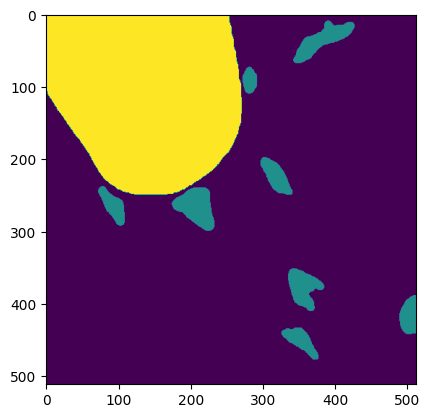

In [119]:
# Color assignment for blood vessel, glomerulus, and unsure will not be fixed 
# change depending if these are in a particular image
plt.imshow(mask)

In [141]:
# Read image from masks_4d (grey background) or masks_4d_alt(white background)
# using plt.imread
mask_file_path_alt = '/gdrive/MyDrive/DATA/HuBMAP/masks_4d_alt/0006ff2aa7cd_mask.tif'
mask_alt = plt.imread(mask_file_path_alt)

In [142]:
mask_alt.shape

(512, 512, 4)

In [143]:
mask_alt

array([[[255, 255, 255, 255],
        [255, 255,   0, 255],
        [255, 255,   0, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255, 255,   0, 255],
        [255, 255,   0, 255],
        [255, 255,   0, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255, 255,   0, 255],
        [255, 255,   0, 255],
        [255, 255,   0, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       ...,

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255

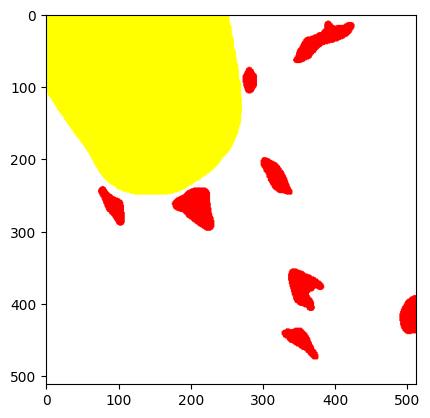

In [144]:
plt.imshow(mask_alt)

In [ ]:
# https://pyimagesearch.com/2021/01/23/splitting-and-merging-channels-with-opencv/
# https://stackoverflow.com/questions/42406338/why-cv2-imwrite-changes-the-color-of-pics
# https://stackoverflow.com/questions/63289840/quick-way-to-convert-image-3-channels-depth-to-1-channel-in-python

In [110]:
!ls /gdrive/MyDrive/DATA/HuBMAP

annotation_info.csv  masks_3d		    test_list.csv   wsi_meta.csv
images		     polygons.jsonl	    tile_meta.csv
images_info.csv      sample_submission.csv  train_list.csv
masks		     test		    val_list.csv


In [194]:
annotation_info = pd.read_csv('/gdrive/MyDrive/DATA/HuBMAP/annotation_info.csv',index_col=0)
annotation_info[annotation_info.unsure > 0]

blood_vessel  glomerulus  unsure
0033bbc76b6b             3           0       1
00656c6f2690             9           0       1
0067d5ad2250             6           0       3
0596bfb19322             4           0       2
06034408218a             7           0       1
...                    ...         ...     ...
f86347534ec1            20           0       1
fa207406c405            10           1       6
faba1bf818ae             6           0       4
fc6def641612             3           0       3
fd2437954fd8             4           0       1

[359 rows x 3 columns]

In [148]:
mask_ids = annotation_info.index.tolist()

In [ ]:
file_path = '/gdrive/MyDrive/DATA/HuBMAP/masks/'

id: 68c4d1b29b13:: Blood Vessel count: 8	 Glomerulus count:            0	Unsure count: 0
id: 720c0fa5ce8e:: Blood Vessel count: 3	 Glomerulus count:            0	Unsure count: 0
id: 4021872b194c:: Blood Vessel count: 6	 Glomerulus count:            1	Unsure count: 0
id: c7d49f3f1ae3:: Blood Vessel count: 1	 Glomerulus count:            0	Unsure count: 6
id: dd690b7d9a47:: Blood Vessel count: 1	 Glomerulus count:            0	Unsure count: 7
id: 3dbff16df8b4:: Blood Vessel count: 6	 Glomerulus count:            1	Unsure count: 0


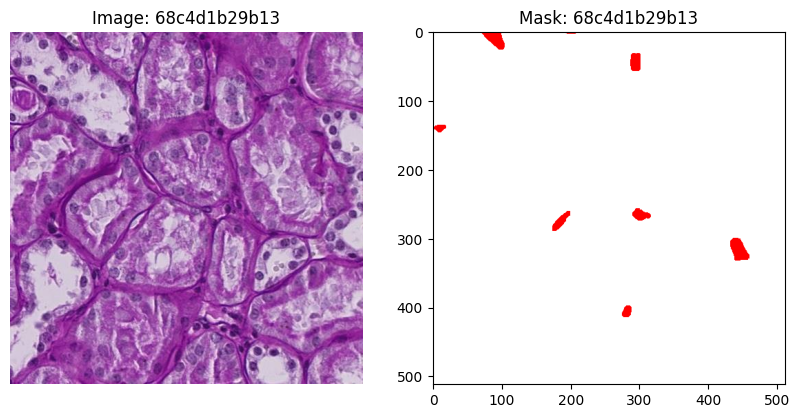

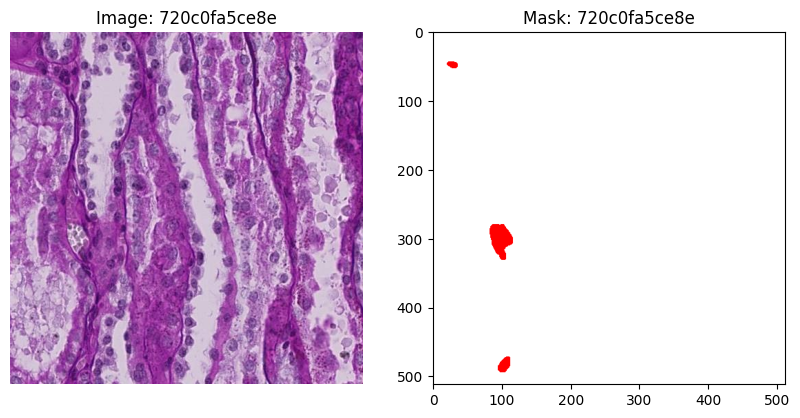

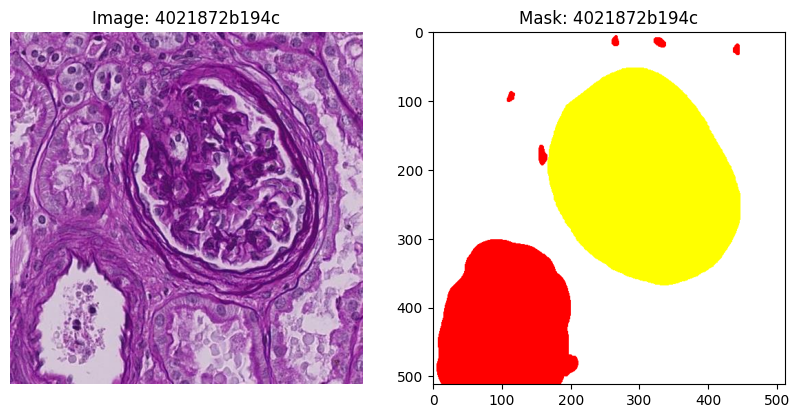

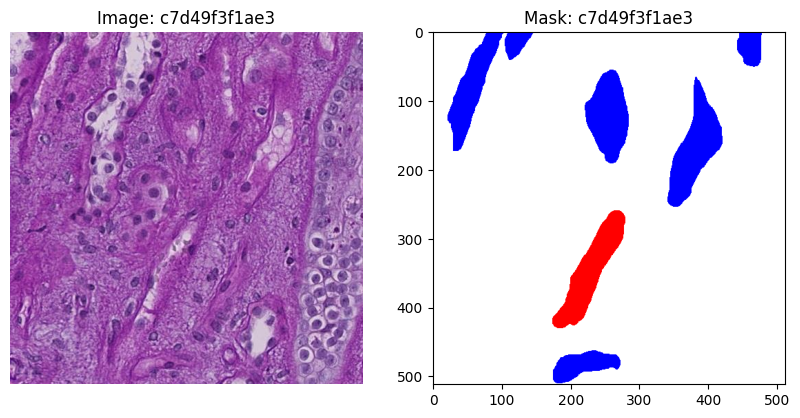

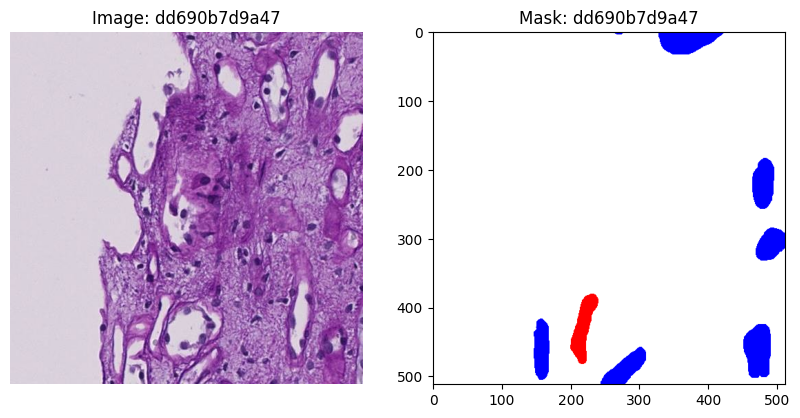

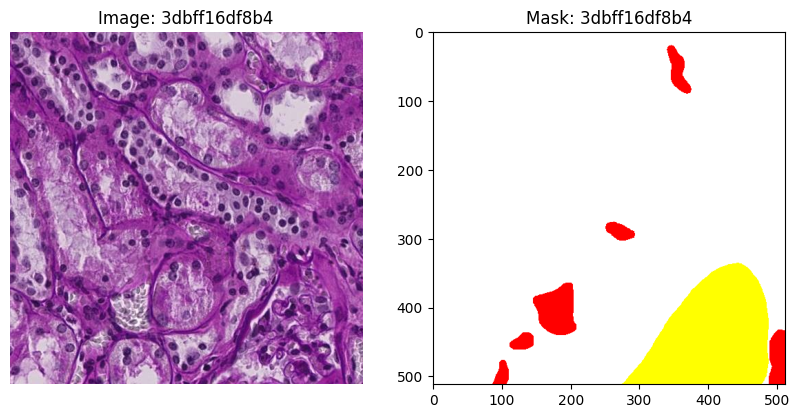

In [154]:
# Show images and masks
id_list = []
for i in range(6):
  idx_num = np.random.randint(len(mask_ids))

  id = mask_ids[idx_num]
  id_list.append(id)

  img_file_path = file_path + 'images/' + id + '.tif'
  mask_file_path = file_path + 'masks_4d_alt/' + id +'_mask.tif'

  image = plt.imread(img_file_path)
  mask = plt.imread(mask_file_path)

  plt.figure(figsize=(10,10))
  plt.subplot(1,2,1)
  plt.imshow(image)
  plt.title('Image: '+id)
  plt.axis('off')

  plt.subplot(1,2,2)
  plt.imshow(mask)
  plt.title('Mask: '+id)
  plt.axis('on')

if len(id_list) == 6:
  for id in id_list:
      blood_vessel_count = annotation_info.loc[id,'blood_vessel']
      glomerulus_count = annotation_info.loc[id,'glomerulus']
      unsure_count = annotation_info.loc[id,'unsure']
      print(f"id: {id}:: Blood Vessel count: {blood_vessel_count}\t Glomerulus count:\
            {glomerulus_count}\tUnsure count: {unsure_count}")

In [195]:
# How to display model prediction masks
id = 'fa207406c405' #id_list[2]
# prediction mask is numpy array 
pred = cv2.imread(file_path + '/masks/' + id +'_mask.tif',cv2.IMREAD_GRAYSCALE)
pred.shape


(512, 512)

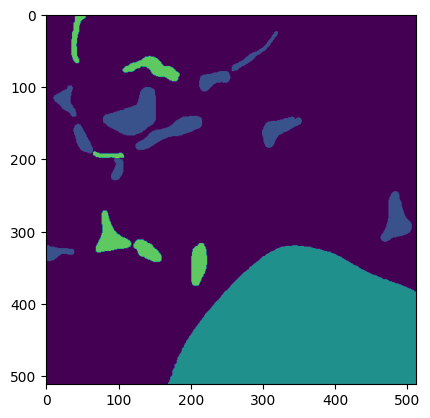

In [196]:
# Color assignment to different region is not fixed and changes if pred is displayed
plt.imshow(pred)

In [197]:
pred

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2]], dtype=uint8)

In [198]:
  # Color assign each class (background, blood vessel, glomerulus and unsure)
  # a distinct color to be displayed with when viewd
  palette = [255,255,255,     # 0=white
            255,0,0,          # 1= red
            255,255,0,        # 2=yellow
            0,0,255]          # 3=blue
  
  # Pad with zeroes to 768 values, i.e. 256 RGB colours
  palette = palette + [0]*(768-len(palette))

  # Convert Numpy array to palette image
  pred_pi = Image.fromarray(pred,'P')

  # Put the palette in
  pred_pi.putpalette(palette)
  

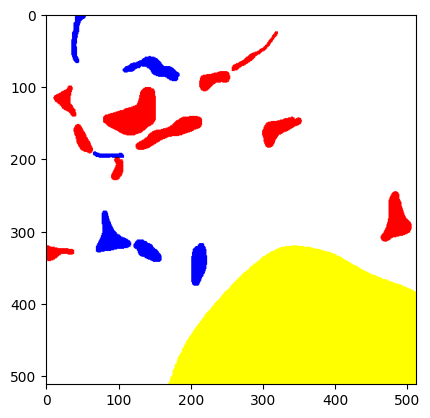

In [199]:
# Color assignment to different regions is kept fixed
# background -- > white
# blood vessel --> red
# glomerulus --> yellow
# unsue --> blue
plt.imshow(pred_pi);